In [2]:
from pathlib import Path
import numpy as np
import sys
import importlib

In [3]:
working_dir = Path('../input_files/magshockz-v3.1.2d')
input_file = working_dir / 'magshockz-v3.1.1d'

py_script = working_dir / 'py-script-1d.py'



def read_sim_bounds(input_file: Path, ion_scales = False):
    xmin, xmax = None, None

    def search_line(line: str, splitter: str):
        return line.split(splitter)[1].split(',')[0].strip()

    with input_file.open() as f:
        for line in f:
            line = line.lstrip()
            if line.startswith("xmax"):
                if ion_scales:
                    xmax = float(search_line(line, "=")) * .1
                else:
                    xmax = float(search_line(line, "="))
            elif line.startswith("xmin"):
                if ion_scales:
                    xmin = float(search_line(line, "=")) * .1
                else:
                    xmin = float(search_line(line, "="))

    if xmin is None or xmax is None:
        raise ValueError("xmin or xmax not found in the input file")
    
    sys.path.append(working_dir.as_posix())
    pyt = importlib.import_module(py_script.stem)
    if ion_scales:
        for (key,val) in pyt.box_bounds.items():
            pyt.box_bounds[key] = val * .1

    return xmax-xmin,pyt


d, pyt = read_sim_bounds(input_file)

print(pyt.box_bounds)

{'xmin': -3357.0, 'xmax': 3357.0, 'ymin': -307.0, 'ymax': 8407.0}


{'xmin': -3357.0, 'xmax': 3357.0, 'ymin': -307.0, 'ymax': 8407.0}


/tmp/ipykernel_1109617/3211837942.py:23: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(data.T), origin='lower',
/tmp/ipykernel_1109617/3211837942.py:27: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.load(working_dir / 'interp' / 'aldens.npy').T), origin='lower', cmap = 'plasma',


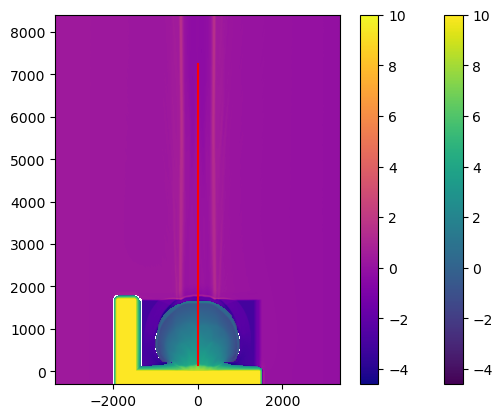

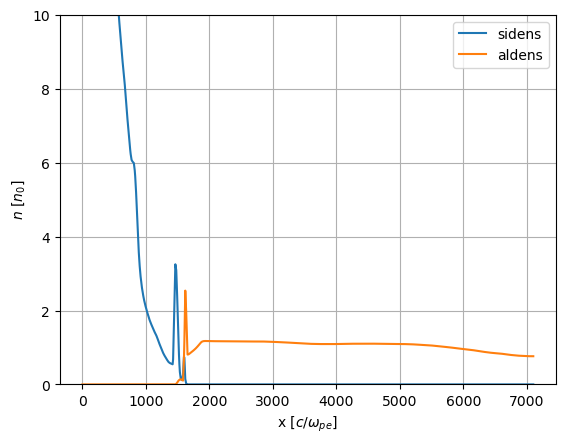

In [ ]:
import matplotlib.pyplot as plt


field = 'sidens.npy'
pyt.theta = np.pi/2

print(pyt.box_bounds)
def plot_line_on_density(field):
    if field.endswith('.npy'):
        data = np.load(working_dir / 'interp' / field)

    elif field.endswith('.pkl'):
        import pickle
        with open(working_dir/ 'interp'/ field, "rb") as p:
            f = pickle.load(p)
            x = np.linspace(pyt.box_bounds['xmin']+8, pyt.box_bounds['xmax']-8, 1000)
            y = np.linspace(pyt.box_bounds['ymin']+8, pyt.box_bounds['ymax']-8, 1000)
            x1,x2 = np.meshgrid(y,x)
        data = f((x1,x2))

    plt.figure()

    plt.imshow(np.log(data.T), origin='lower',
                extent=[pyt.box_bounds['xmin'], pyt.box_bounds['xmax'], pyt.box_bounds['ymin'], pyt.box_bounds['ymax']],vmax = 10)
    # plt.colorbar()
    
    plt.imshow(np.log(np.load(working_dir / 'interp' / 'aldens.npy').T), origin='lower', cmap = 'plasma',
                extent=[pyt.box_bounds['xmin'], pyt.box_bounds['xmax'], pyt.box_bounds['ymin'], pyt.box_bounds['ymax']],vmax = 10)
    # plt.colorbar()

    plt.plot([pyt.start_point[0], pyt.start_point[0]+d*np.cos(pyt.theta)], [pyt.start_point[1],pyt.start_point[1]+d*np.sin(pyt.theta)],color='r')
    plt.show()
    return

plot_line_on_density(field = field)

def make_1d_plot(field):
    from scipy.interpolate import RegularGridInterpolator

    x_osiris = np.linspace(pyt.start_point[0], pyt.start_point[0] + d*np.cos(pyt.theta),1000)
    y_osiris = np.linspace(pyt.start_point[1], pyt.start_point[1] + d*np.sin(pyt.theta),1000)

    if field.endswith('.npy'):
        data = np.load(working_dir / 'interp' / field)

        x = np.linspace(pyt.box_bounds['xmin'], pyt.box_bounds['xmax'], data.shape[0])
        y = np.linspace(pyt.box_bounds['ymin'], pyt.box_bounds['ymax'], data.shape[1])
        f = RegularGridInterpolator((x, y), np.load(working_dir / 'interp' / field))
        plt.plot(np.linspace(0, d, 1000), f((x_osiris,y_osiris)), label=f"{field.strip('.npy')}")
        plt.ylim(0,10)
        plt.xlabel(r'x [$c/\omega_{pe}$]')
        plt.ylabel(r'$n$ [$n_0$]')

    elif field.endswith('.pkl'):
        import pickle
        with open(working_dir/ 'interp'/ field, "rb") as p:
            f = pickle.load(p)
    
            plt.plot(np.linspace(0, d, 1000), f((y_osiris,x_osiris)), label=f"{field.strip('.pkl')}")

    plt.grid(visible=True)    
    plt.legend()
    return

make_1d_plot(field = field)
make_1d_plot(field = 'aldens.npy')
# make_1d_plot(field = 'magy.pkl')
# make_1d_plot(field = 'magz.pkl')